From the models tried so far,we got best performance from fine tuning model of roberta,so lets take that as best model and built the final model.

In [1]:
import re
import os
import shutil
import datetime
import gc
import nltk
import pickle
import codecs
import warnings
warnings.filterwarnings("ignore")
import scipy
from scipy import sparse
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style='whitegrid')
from sklearn import preprocessing
from collections import Counter
import string
from nltk.corpus import stopwords
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten,concatenate,LSTM,Lambda
from tensorflow.keras.layers import Embedding
import tensorflow.keras
from tensorflow.keras.models import Model,load_model,Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [2]:
train = pd.read_csv('train.csv').fillna('') #there is one null value,replace it with ''
test = pd.read_csv('test.csv')
train.shape,test.shape

((27481, 4), (3534, 3))

Performance Metric

In [3]:
def jaccard(str1, str2): #function for finding jaccard similarity for given two sentences
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

Final best model-Roberta

In [4]:
!pip install transformers

In [4]:
from transformers import RobertaTokenizer, TFRobertaForQuestionAnswering #importing necessary libraries

In [5]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base') #initialsie pre trained tokenizer and get the pre trained  model with weights
robert_model = TFRobertaForQuestionAnswering.from_pretrained('roberta-base') #we will use roberta-base here

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaForQuestionAnswering: ['lm_head']
- This IS expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFRobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
robert_model.summary() #768*2=1536+2bias = 1538  dense layer with 2 neurons,as there are two labels

Model: "tf_roberta_for_question_answering"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
roberta (TFRobertaMainLayer) multiple                  124645632 
_________________________________________________________________
qa_outputs (Dense)           multiple                  1538      
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


In [8]:
from sklearn.model_selection import train_test_split #split train and cv data
x_train,x_cv,y_train,y_cv=train_test_split(train,train.sentiment,test_size=0.10,stratify=train.sentiment) #split wrt sentiment so that their distribution is equal in cv and train data
x_train.shape,x_cv.shape #train and cv data shapes

((24732, 4), (2749, 4))

In [9]:
train_idx = x_train.index.values
cv_idx = x_cv.index.values
train_idx.shape,cv_idx.shape

((24732,), (2749,))

In [9]:
text, question = list(train['text']),list(train['sentiment']) #get the tokenized values of given sentiment and and text values
input_dict = tokenizer(text, question, padding=True,return_tensors='tf') #you can take question first and then text, but during extracting output labels make sure you extract them accordingly

In [10]:
max=0
for i in input_dict['input_ids']:
    if len(i)>max:
        max=len(i)
print("maximum length of text as per tokenisation of roberta is:",max)

#attention = np.array(input_dict['attention_mask']) shape:(27480,105)

maximum length of text as per tokenisation of roberta is: 105


Extracting output labels for start and end tokens seperately

In [11]:
#this extraction is inspired from this link :https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705/comments#Training-Data
len_t = train.shape[0]
#len_t=1
MAX_LEN = 105
start_tokens = np.zeros((len_t,MAX_LEN),dtype='int32')
end_tokens = np.zeros((len_t,MAX_LEN),dtype='int32')
for k in range(0,train.shape[0]):
    text_t = " "+" ".join(train.loc[k,'text'].split())
    text_s = " ".join(train.loc[k,'selected_text'].split())
    #print(text_t)
    #print(text_s)
    idx = text_t.find(text_s)
    #print(idx)
    chars = np.zeros((len(text_t)))
    chars[idx:idx+len(text_s)]=1
    
    if text_t[idx-1]==' ':
        chars[idx-1] = 1 
    #print(chars)
    #print("length of chars:",len(chars))
    offsets = []; idx=0
    enc = tokenizer.encode(text_t)
    for t in enc:
            w = tokenizer.decode([t])
            #print(w,t)
            if t==0 or t==2:
                offsets.append((idx,idx+0))
                idx +=0
            else:
                offsets.append((idx,idx+len(w)))
                idx += len(w)
    #print(offsets)
    toks = []
    s= np.argmax(chars)
    e= len(chars)-1-np.argmax(chars[::-1])
    #print("common:",s,e)
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0:
            toks.append(i) 
    #print(toks)
    if len(toks)>0:
            start_tokens[k,toks[0]] = 1
            end_tokens[k,toks[-1]+1] = 1
    #print(tokenizer.decode(enc[toks[0]:toks[-1]+1]))
    
start_tokens.shape,end_tokens.shape

((27481, 105), (27481, 105))

Model Architecture

In [8]:
def build_model():
    x_ids = Input(shape=(105,),dtype=tf.int32)
    x_att = Input(shape=(105,),dtype=tf.int32)
  #robert_model = TFRobertaForQuestionAnswering.from_pretrained('roberta-base')
    outputs = robert_model(x_ids,attention_mask=x_att)  #dense layer with 2 neurons and activation=none
    #these outputs are logits before softmax,so we have to do softmax
   
    o1 = tf.keras.layers.Activation('softmax')(outputs[0])
    o2 = tf.keras.layers.Activation('softmax')(outputs[1])
    model = Model(inputs=[x_ids,x_att], outputs=[o1,o2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    #labels = [start,end]
    #loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) #we can do this or take softmax layers seperately as above o1 and o2
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return model

In [13]:
final = build_model()
final.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 105)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 105)]        0                                            
__________________________________________________________________________________________________
tf_roberta_for_question_answeri ((None, 105), (None, 124647170   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 105)          0           tf_roberta_for_questio

###Model training

In [ ]:
#K.clear_session()
x_train1,x_train2=np.array(input_dict['input_ids'])[train_idx,],np.array(input_dict['attention_mask'])[train_idx,]
x_cv1,x_cv2  =    np.array(input_dict['input_ids'])[cv_idx,],np.array(input_dict['attention_mask'])[cv_idx,]
start,end = start_tokens[train_idx,],end_tokens[train_idx,]
y_s,y_e   = start_tokens[cv_idx,],end_tokens[cv_idx,]
#callbacks for our required tasks
#you cant save a subclassed model in keras, raising NotImplementedError: so save only weights
#https://github.com/keras-team/keras/issues/12922
#https://stackoverflow.com/questions/51806852/cant-save-custom-subclassed-model
saving  = ModelCheckpoint("/content/best_model_{loss:.4f}.h5", monitor='loss', verbose=1, save_best_only=True,save_weights_only=True, mode='auto', save_freq='epoch')
tensorboard_callback = TensorBoard(log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),histogram_freq=1, write_graph=True,write_grads=True)
lr_red = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto',min_delta=0.000000001)

final_model = build_model()

history1 = final_model.fit([x_train1,x_train2],[start,end],epochs=10,batch_size=32,validation_data=([x_cv1,x_cv2],[y_s,y_e]),callbacks=[tensorboard_callback,saving,lr_red])

Epoch 1/10
  1/773 [..............................] - ETA: 0s - loss: 9.2907 - activation_14_loss: 4.6783 - activation_15_loss: 4.6124WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
773/773 [==============================] - ETA: 0s - loss: 2.7822 - activation_14_loss: 1.1788 - activation_15_loss: 1.6034
Epoch 00001: loss improved from inf to 2.78221, saving model to /content/best_model_2.7822.h5
773/773 [==============================] - 1288s 2s/step - loss: 2.7822 - activation_14_loss: 1.1788 - activation_15_loss: 1.6034 - val_loss: 2.0306 - val_activation_14_loss: 0.8928 - val_activation_15_loss: 1.1378
Epoch 2/10
773/773 [==============================] - ETA: 0s - loss: 1.9251 - activation_14_loss: 0.8856 - activation_15_loss: 1.0395
Epoch 00002: loss im

In [14]:
!rm -rf ./logs/ 

Predictions

In [21]:
p_model = build_model()
p_model.load_weights('/content/best_model_1.6744.h5') #pick the best model which is neither underfitting nor overfitting

In [22]:
start_pred,end_pred = p_model.predict([x_train1,x_train2]) #predict on train data
start_pred.shape,end_pred.shape

((24732, 105), (24732, 105))

In [26]:
predict=[] #final outputs of train data and decoding to get predicted selected text values
actual=[]
for i,j in enumerate(train_idx):
    #print(j)
    s=np.argmax(start_pred[i]) #get index of maximum value
    e=np.argmax(end_pred[i])
    #print(s,e)
    if s<=e: #if start token index is less than end token index
        op = tokenizer.decode(input_dict['input_ids'][j:j+1].numpy()[0][s:e+1]) #take that output
        #print(op)
        op = op.replace('</s>','')
        op = op.replace('<pad>','')
        
        predict.append(op)
        #print("output",op,'\n')
        actual.append(train[j:j+1]['selected_text'].values[0])
    else: #if start token is greater than end token

    #this extraction of output where indexes of  end token>start token may yield different results based on the way we select the indexes,so we have to experiment with it and select
    #the best condition which yields the best score
    #from naive model predictions,it's clear that taking text as it is may yield good predictions, so,  take the whole text as it as selected text for this condition
        #print("as:",train[j:j+1]['text'].values[0])
        #print(train[j:j+1]['selected_text'].values[0])
        op = train[j:j+1]['text'].values[0]
        actual.append(train[j:j+1]['selected_text'].values[0])
        #op = tokenizer.decode(text['input_ids'][j:j+1].numpy()[0][e:s+1])
        #op = op.replace('</s>','')
        #op = op.replace('<s>','')
        #op = op.replace('<pad>','')
        #print("output",op,'\n')
        #print(train[j:j+1]['selected_text'].values[0])
        predict.append(op)

In [7]:
js=0   
for i in range(train_idx.shape[0]):
  try: #neglecting null value row in train as it raises zero division error
      js = js + jaccard(predict[i],actual[i])
  except:
    print(i)
print("final jaccard score for train data:",js/(train_idx.shape[0]))

5812
final jaccard score for train data: 0.6961233036543418


### CV data

In [32]:
#%%time
start_predv,end_predv = p_model.predict([x_cv1,x_cv2]) #predictions on cv data
start_predv.shape,end_predv.shape

((2749, 105), (2749, 105))

In [33]:
predictv=[]
actualv=[]
for i,j in enumerate(cv_idx):
    #print(j)
    s=np.argmax(start_predv[i])
    e=np.argmax(end_predv[i])
    #print(s,e)
    if s<=e:
        op = tokenizer.decode(input_dict['input_ids'][j:j+1].numpy()[0][s:e+1])
        #print(op)
        op = op.replace('</s>','')
        op = op.replace('<pad>','')
        
        predictv.append(op)
        #print("output",op,'\n')
        actualv.append(train[j:j+1]['selected_text'].values[0])
    else:
        #print("as:",train[j:j+1]['text'].values[0])
        #print(train[j:j+1]['selected_text'].values[0])
        op = train[j:j+1]['text'].values[0]
        actualv.append(train[j:j+1]['selected_text'].values[0])
        #op = tokenizer.decode(text['input_ids'][j:j+1].numpy()[0][e:s+1])
        #op = op.replace('</s>','')
        #op = op.replace('<s>','')
        #op = op.replace('<pad>','')
        #print("output",op,'\n')
        #print(train[j:j+1]['selected_text'].values[0])
        predictv.append(op)

In [8]:
js=0   
for i,j in enumerate(cv_idx):
    try: #an index  has empty values in train data,so predicting jaccard score results in zero division error,so just leave out that row
        js = js + jaccard(predictv[i],actualv[i])
    except:
      print(i)
print("final jaccard score for cv data:",js/(cv_idx.shape[0]))

final jaccard score for cv data: 0.6728537849264346


# Error Analysis

In [57]:
js=0   
idx=[]
prd=[]
for i,j in enumerate(cv_idx):
      js =  jaccard(predictv[i],actualv[i]) #find jaccard score for each predicted value with actual value
      if js!=1: #if score!=1,take that as error point for which predictions are wrong
        idx.append(j) #take that index number
        prd.append(predictv[i]) #take that predicted value

In [58]:
len(idx),len(prd)

(1551, 1551)

In [54]:
idx[0:10]

[4887, 3208, 4726, 6557, 25820, 14939, 24287, 8800, 14233, 6022]

In [74]:
err = train.iloc[idx] #get those points for which score<1

In [75]:
err['t_len'] = err['text'].str.split().apply(len) #text length (no of words)
err['st_len'] = err['selected_text'].str.split().apply(len) #selected text length
err['predictions'] = prd #predicted values

In [76]:
err['jaccard']  = err.apply(lambda x: jaccard(x.predictions, x.selected_text), axis=1) #jaccard similarity for predicted and actual values

In [69]:
err[0:20] #sample data

,textID,text,selected_text,sentiment,t_len,st_len,predictions,jaccard
4887,22a195f2d7,looks class the water splash looks so real l...,looking forward,positive,15,2,looking,0.500000
3208,9ec935f3c2,cool that`s good. You back on trains for a w...,cool that`s good.,positive,10,3,cool that`s good,0.500000
4726,e04fa17673,graandma`s houseee i havee too leave now! <3,graandma`s houseee i havee too leave now! <3,negative,8,8,i havee too leave now! <3,0.750000
6557,5cfb77397c,Long day at office again. Tiring week,Tiring,negative,7,1,Tiring week,0.500000
25820,84fecbe3bf,"Hope you had a great weekend, congratulations!",great,positive,7,1,"Hope you had a great weekend, congratulations!",0.142857
14939,c6468c160e,Updating to the latest version of Adium now. W...,great,positive,12,1,What a great app,0.250000
24287,b3d7afcea4,_ thats coz we love you,love,positive,6,1,love you,0.500000
8800,5b5c03a5f0,have you read Angels & Demons? What do you th...,? oh and beautiful sunny,positive,23,5,beautiful sunny,0.400000
14233,bf8bf74559,_mit_glee It is confusing and flippin expensive,expensive,negative,7,1,confusing and flippin expensive,0.250000
6022,f9e0a2422d,enjoying my coffee with this super delicious c...,delicious,negative,8,1,enjoying my coffee with this super delicious c...,0.125000


The above tweets have jaccard score < 1 for the extracted text.From first instinct we can observe that the tweets having single word in selected text  predictions are not good.Lets analyse further:

We can see that our model is extracting the phrases correctly from the text given the sentiment.But some of the points having single words as extraced texts so model is not performing well for these type of tweets.Lets do some analysis on these tweets.

Text(0.5, 1.0, 'Kernel Distribution of Number of words with jaccrd score<0.5 in text and selected text of error predictions')

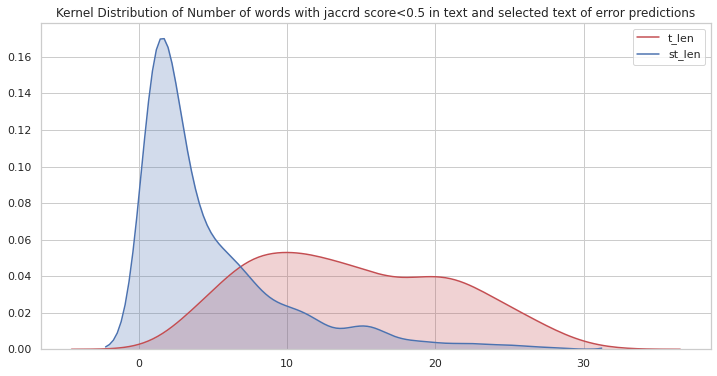

In [77]:
jac_less = err[err['jaccard']<0.5] #take the points where score<0.5
plt.figure(figsize=(12,6))
sns.kdeplot(jac_less['t_len'], shade=True, color="r").set_title('Kernel Distribution of Number of words in text')
sns.kdeplot(jac_less['st_len'], shade=True, color="b").set_title('Kernel Distribution of Number of words with jaccrd score<0.5 in text and selected text of error predictions')

We have picked the tweets for which predicted jaccard score < 0.3 and distribution of number of words in the tweets have been plotted.Number of words in text are almost uniform for 5-25 word length,indicating that there is no much relation between length of sentence and the jaccard score.Even in Selected text dsitribution,we cant infer much.But most of the words in selected text has 1-5 words.

so we can't infer much using numer of words, lets see word distribution.

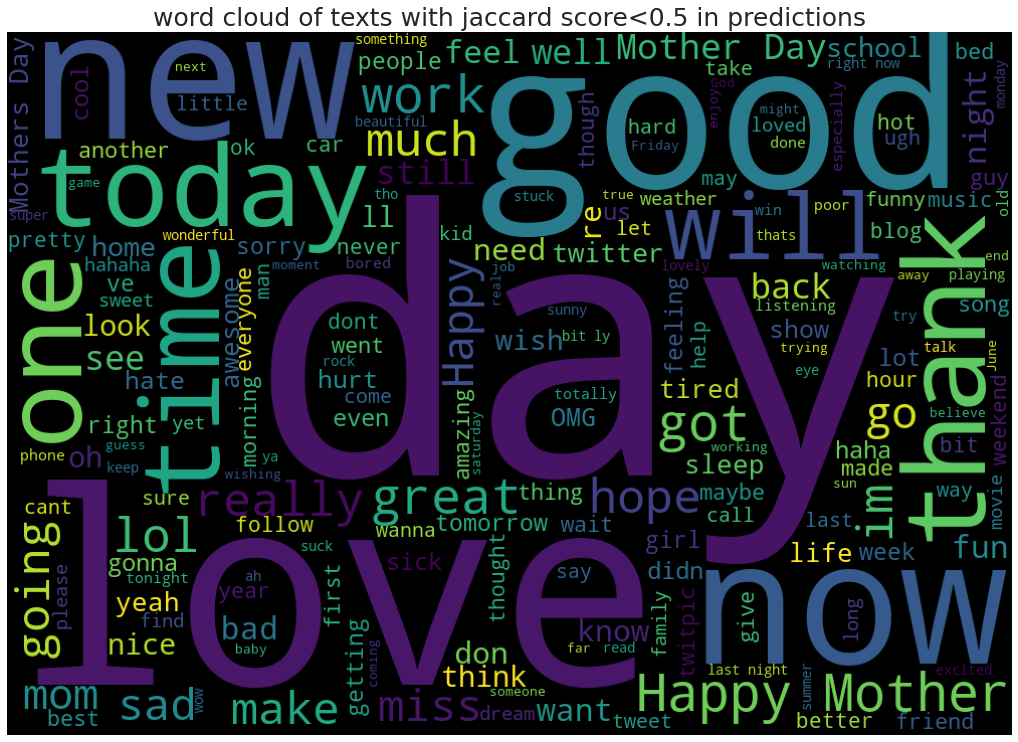

In [72]:
from wordcloud import WordCloud
wc = WordCloud(max_words=200,width = 1000, height = 700).generate(" ".join(jac_less.text.astype(str)))
plt.figure(figsize = (18, 13))
plt.title('word cloud of texts with jaccard score<0.5 in predictions',fontsize=25)
plt.imshow(wc)
plt.axis("off")
plt.show()

Above word cloud shows that positive sentiment words like good,love,thank,happy... and also neutral sentiment words like day,new,now...occuring more frequently in the tweets where jaccard score < 0.5, indicating that there is no much we can infer and the extraction of the words from given text seems random and data itself has been prepared like that and we cant do much about that.

##Final observation

We can see that the jaccard score is less for the tweets where the number of words in extraced text are 1-5,so if we want to improve model performance,we may take the length of the predictions to be between 1-5 for tweets with jaccard score < 0.5.Apart from that we cant infer much pattern in text data for these less scored tweets.seems like provided data's extraced text itself has been choosen randomly.

If we dont consider score as our final agenda and by interpreting the model,we can see our model is extracting the correct phrases corresponding to the sentiment.If we use any more complex techniques to get the more jaccard score,model will overfit which is not good idea.So we can proceed with this model for our deployment as far as model performance is considered.

#Quantization

In [16]:
print("Best model size in Mb:", os.path.getsize('/content/best_model_1.6744.h5') / float(2**20))

Best model size in Mb: 475.75054931640625


In [9]:
best_model = build_model()
best_model.load_weights('/content/best_model_1.6744.h5') #pick the best model which is neither underfitting nor overfitting

present model is taking 5ms for predicting one point using GPU colab

As the model size is large because of millions of weights, it may raise problem if we have memory and time constraints while deploying,so let's try reducing the size of the model by quantization.As the model is already trained we will use post quantization and reduce the size and check if there is any significant change in model performance.There are some methods in post quantisation,you can refer tflite post quantization for all the details:

https://www.tensorflow.org/lite/performance/post_training_quantization

we will use Float16 quantization here as it can be faster while using GPU,we can try all the methods and pick up the best method based on the trade off between performance,latency and size.

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)

In [13]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.optimizations

[<Optimize.DEFAULT: 'DEFAULT'>]

In [28]:
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_types

[tf.float16]

In [ ]:
tflite_quant_model = converter.convert() #tried converting the model to tflite,but resulted in memory crash,
#may be because there are operations in our model that tflite model is not yet supporting
#i tried converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
# tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.] but didn't wok
#may be there are some operations in roberta model which are not yet supported in tflite model
#we have https://pytorch.org/tutorials/intermediate/dynamic_quantization_bert_tutorial.html in pytorch,but tensorflow wont have any tutorials like this
#https://github.com/tensorflow/tensorflow/issues/29715
#https://www.tensorflow.org/lite/guide/ops_select
#https://blog.rasa.com/compressing-bert-for-faster-prediction-2/

#saving converted model in "converted_quant_model.tflite" file
#open("converted_quant_model.tflite", "wb").write(tflite_quant_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpet2oftca/assets


As there are some operations in our model which are not yet supported by tensorflow lite,we can't convert our model and quantize it as of now.

#FINAL FUNCTIONS

Final function 1: It takes inputs (item's features) in the form of dataframe: ["train_id"-numerical, "text" - string, "sentiment" - string]

It returns the extracted text for the given tweet point.

In [34]:
def tokenize(test): #manual tokenization of given test point
  tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
  sentiment_id = {'positive': 22173, 'negative': 33407, 'neutral': 12516} #token ids of sentiments as per roberta tokenizer
  len_t = test.shape[0] #manual tokenization
  MAX_LEN = 105
  input_ids_t = np.ones((len_t,MAX_LEN),dtype='int32') #maximum length of train texts which is 105
  attention_mask_t = np.zeros((len_t,MAX_LEN),dtype='int32')
  #print(test)
  for k in range(len_t):
      # INPUT_IDS
      text_t = test.iloc[k,1] #get the text value
      #print(text_t)
      enc = tokenizer.encode(text_t)  
      #print(enc)              
      s_tok = sentiment_id[test.iloc[k,2]] #get the sentiment value
      #print(s_tok)
      input_ids_t[k,:len(enc)+3] =  enc + [2] + [s_tok] + [2]
      attention_mask_t[k,:len(enc)+3] = 1
  return input_ids_t,attention_mask_t,tokenizer

In [ ]:
#tokenizer = RobertaTokenizer.from_pretrained('roberta-base') #initialsie pre trained tokenizer and get the pre trained  model with weights
robert_model = TFRobertaForQuestionAnswering.from_pretrained('roberta-base') #we will use roberta-base here

Some weights of the model checkpoint at roberta-base were not used when initializing TFRobertaForQuestionAnswering: ['lm_head']
- This IS expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFRobertaForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFRobertaForQuestionAnswering were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def build_model():
    x_ids = Input(shape=(105,),dtype=tf.int32)
    x_att = Input(shape=(105,),dtype=tf.int32)
  #robert_model = TFRobertaForQuestionAnswering.from_pretrained('roberta-base')
    outputs = robert_model(x_ids,attention_mask=x_att)  #dense layer with 2 neurons and activation=none
    #these outputs are logits before softmax,so we have to do softmax
   
    o1 = tf.keras.layers.Activation('softmax')(outputs[0])
    o2 = tf.keras.layers.Activation('softmax')(outputs[1])
    model = Model(inputs=[x_ids,x_att], outputs=[o1,o2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    #labels = [start,end]
    #loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True) #we can do this or take softmax layers seperately as above o1 and o2
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return model

In [14]:
def extract_output(input_ids_t,start_predt,end_predt,test,tokenizer):
  predictt=[]
  for i in range(0,input_ids_t.shape[0]):
      #print(j)
      s=np.argmax(start_predt[i])
      e=np.argmax(end_predt[i])
      #print(s,e)
      if s<=e:
          op = tokenizer.decode(input_ids_t[i:i+1][0][s:e+1])
          #print(op)
          op = op.replace('</s>','')
          op = op.replace('<pad>','')
          predictt.append(op)
          #print("output",op,'\n')
          
      else:
          #print("as:",train[j:j+1]['text'].values[0])
          #print(train[j:j+1]['selected_text'].values[0])
          op =test[i:i+1]['text'].values[0]
          #print(train[j:j+1]['selected_text'].values[0])
          predictt.append(op)
  return predictt

##FINAL FUNCTION1

In [36]:
def final_fun_1(x):
  input_ids,attention_mask,tokenizer = tokenize(x) #tokenize the given text
  best_model = build_model()
  best_model.load_weights('/content/best_model_1.6744.h5') #pick the best model which is neither underfitting nor overfitting
  start_pred,end_pred = best_model.predict([input_ids,attention_mask]) #predict on given data
  prediction = extract_output(input_ids,start_pred,end_pred,x,tokenizer) #extract output from predictions

  return prediction

In [41]:
example = test[20:21]
pred = final_fun_1(example)
print("input text:",example['text'].values[0])
print("extracted text for given tweets:",pred)

input text: Stupid storm. No river for us tonight
extracted text for given tweets: ['Stupid']


##FINAL FUNCTION2

In [ ]:
def jaccard(str1, str2): #function for finding jaccard similarity for given two sentences
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [42]:
def final_fun_2(x, y):
  predicted_value = final_fun_1(x) #using function1 predict the price of an item
  true_value = y #true value of an item
  return jaccard(true_value[0],predicted_value[0]) #as both are lists,take only the first value as jaccard function is for calculation of single sentence 

In [45]:
example = test[20:21]
true_output = ['stupid']
jaccard_score = final_fun_2(example,true_output)
print('JACCARD score for given inputs is ',jaccard_score)

JACCARD score for given inputs is  1.0
